In [2]:
import gymnasium as gym
import random
import source.config as config
import source.farm_env # Import necessary to register the gym environment

In [3]:
env = gym.make(id='FarmEnv-v0',
                initial_budget = config.INITIAL_BUDGET,
                sheep_cost = config.SHEEP_COST,
                wheat_cost = config.WHEAT_COST,
                wool_price = config.WOOL_PRICE,
                wheat_price = config.WHEAT_PRICE,
                max_years = config.MAX_YEARS,
                wool_fixed_cost = config.WOOL_FIXED_COST,
                storm_probability = config.STORM_PROBABILITY,
                incest_penalty = config.INCEST_PENALTY,
                )

In [60]:
observation, info = env.reset()
print(observation, info)

{'budget': 2, 'sheep_count': 0, 'bought_sheep_count': 0, 'year': 0} {}


In [59]:
env.step(1)

({'budget': 2.599999999999993,
  'sheep_count': 0,
  'bought_sheep_count': 0,
  'year': 55},
 0.029999999999999805,
 True,
 True,
 {})

In [61]:
observation, info = env.reset()
for _ in range(30):
    options = env.unwrapped.actions_available
    random_action = random.choice(options)
    
    observation, reward, terminated, truncated, info = env.step(random_action)
    print(random_action, observation, reward, terminated, truncated, info)
    if terminated or truncated:
        print("============End of episode============")
        observation, info = env.reset()
        break
env.close()

2 {'budget': 2.0, 'sheep_count': 0, 'bought_sheep_count': 0, 'year': 1} 0.0 False False {}
1 {'budget': 2.03, 'sheep_count': 0, 'bought_sheep_count': 0, 'year': 2} 0.029999999999999805 False False {}
2 {'budget': 2.03, 'sheep_count': 0, 'bought_sheep_count': 0, 'year': 3} 0.0 False False {}
1 {'budget': 2.0599999999999996, 'sheep_count': 0, 'bought_sheep_count': 0, 'year': 4} 0.029999999999999805 False False {}
2 {'budget': 2.0599999999999996, 'sheep_count': 0, 'bought_sheep_count': 0, 'year': 5} 0.0 False False {}
0 {'budget': 1.0609999999999995, 'sheep_count': 1, 'bought_sheep_count': 1, 'year': 6} -0.9990000000000001 False False {}
2 {'budget': 1.0619999999999994, 'sheep_count': 1, 'bought_sheep_count': 1, 'year': 7} 0.0009999999999998899 False False {}
2 {'budget': 1.0629999999999993, 'sheep_count': 1, 'bought_sheep_count': 1, 'year': 8} 0.0009999999999998899 False False {}
2 {'budget': 1.0639999999999992, 'sheep_count': 1, 'bought_sheep_count': 1, 'year': 9} 0.0009999999999998899 

----------------

In [1]:
import gymnasium as gym
import source.config as config
from source.algorithms import FarmAgentSarsaVFA, FarmAgentMCVFA
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import source.farm_env # Import necessary to register the gym environment

In [2]:
env = gym.make(id='FarmEnv-v0',
                initial_budget = config.INITIAL_BUDGET,
                sheep_cost = config.SHEEP_COST,
                wheat_cost = config.WHEAT_COST,
                wool_price = config.WOOL_PRICE,
                wheat_price = config.WHEAT_PRICE,
                max_years = config.MAX_YEARS,
                wool_fixed_cost = config.WOOL_FIXED_COST,
                storm_probability = config.STORM_PROBABILITY,
                incest_penalty = config.INCEST_PENALTY,
                )

In [5]:
learning_rate = 0.001
n_episodes = 50_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

MC_vfa_agent = FarmAgentMCVFA(
    environment=env, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

SARSA_vfa_agent = FarmAgentSarsaVFA(
    environment=env, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

# Montecarlo VFA

In [6]:
nenv = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
final_budget_queue = []
for episode in tqdm(range(n_episodes)):
    MC_vfa_agent.update()
    MC_vfa_agent.decay_epsilon()
    final_budget_queue.append(nenv.unwrapped.budget)

100%|██████████| 50000/50000 [1:46:34<00:00,  7.82it/s]     


Statistics evaluation

In [7]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win
w = 1000
# rewards = conv(np.array(nenv.return_queue).flatten(), win=w)
# lengths = conv(np.array(nenv.length_queue).flatten(), win=w)
error = conv(np.array(MC_vfa_agent.training_error).flatten(), win=w)
final_budgets = conv(np.array(final_budget_queue), win=w)

In [12]:
len(error), len(final_budgets)

(1500000, 50000)

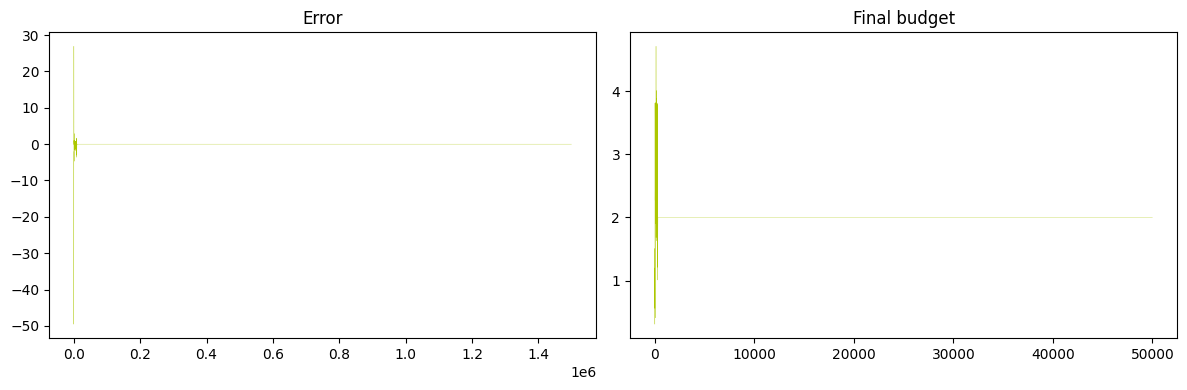

In [8]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
sns.lineplot(x=range(len(np.array(MC_vfa_agent.training_error).flatten())), y=np.array(MC_vfa_agent.training_error).flatten(), ax=ax[0], c='#acc700', linewidth=.2)
ax[0].set_title('Error')
sns.lineplot(x=range(len(final_budget_queue)), y=final_budget_queue, ax=ax[1], c='#acc700', linewidth=.2)
ax[1].set_title('Final budget')
plt.tight_layout()
plt.show()

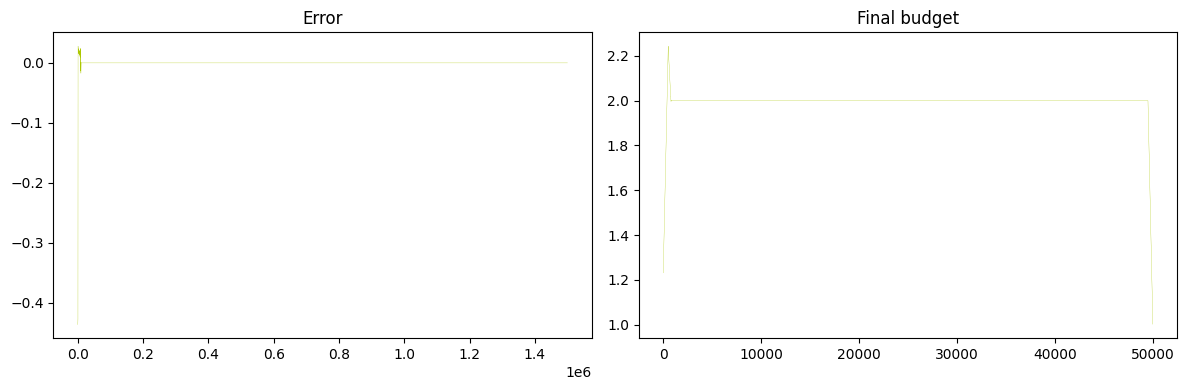

In [10]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
sns.lineplot(x=range(len(error)), y=error, ax=ax[0], c='#acc700', linewidth=.2)
ax[0].set_title('Error')
sns.lineplot(x=range(len(final_budgets)), y=final_budgets, ax=ax[1], c='#acc700', linewidth=.2)
ax[1].set_title('Final budget')
plt.tight_layout()
plt.show()

In [13]:
MC_vfa_agent.w

tensor([[-3.3126e-03, -2.6543e-02, -2.6892e-03, -6.5563e-03, -3.9163e-03],
        [-2.7396e-04,  2.7284e-03, -8.7635e-03, -1.0092e-02, -5.0281e-03],
        [ 7.6063e-07,  5.7413e-07,  4.3547e-06,  7.4319e-07, -3.5695e-03]],
       dtype=torch.float64, requires_grad=True)

In [14]:
np.save('data/MCVFA/MC_weights_GREEDY.npy', MC_vfa_agent.w.detach().numpy())
np.save('data/MCVFA/final_budget_queue_GREEDY.npy', np.array(final_budget_queue))
# np.save('data/MCVFA/training_error.npy', np.array(MC_vfa_agent.training_error).flatten())
# Split the 15M training error records in two chunks not to exceed GitHub limit of 100MB per file
np.save('data/MCVFA/training_error_0k-750k_GREEDY.npy', MC_vfa_agent.training_error[: len(MC_vfa_agent.training_error) // 2])
np.save('data/MCVFA/training_error_750k-1.5M_GREEDY.npy', MC_vfa_agent.training_error[len(MC_vfa_agent.training_error) // 2 : ])

# SARSA VFA

In [8]:
nenv = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
final_budget_queue = []
for episode in tqdm(range(n_episodes)):
    state, info = nenv.reset()
    done = False
    while not done:
        action = SARSA_vfa_agent.policy(state)
        # print(action)
        s_prime, reward, terminated, truncated, info = nenv.step(action=action)
        # update
        SARSA_vfa_agent.update(state, action, reward, s_prime)
        done = terminated or truncated
        state = s_prime
    SARSA_vfa_agent.decay_epsilon()
    final_budget_queue.append(nenv.unwrapped.budget)

  0%|          | 0/100000 [00:00<?, ?it/s]


RuntimeError: inconsistent tensor size, expected tensor [15] and src [4] to have the same number of elements, but got 15 and 4 elements respectively

Statistics evaluation

In [ ]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win
w = 100
rewards = conv(np.array(nenv.return_queue).flatten(), win=w)
lengths = conv(np.array(nenv.length_queue).flatten(), win=w)
error = conv(np.array(SARSA_vfa_agent.training_error).flatten(), win=w)
final_budgets = conv(np.array(final_budget_queue), win=w)

In [20]:
len(rewards),len(lengths),len(SARSA_vfa_agent.training_error)

(1000, 1000, 30000)

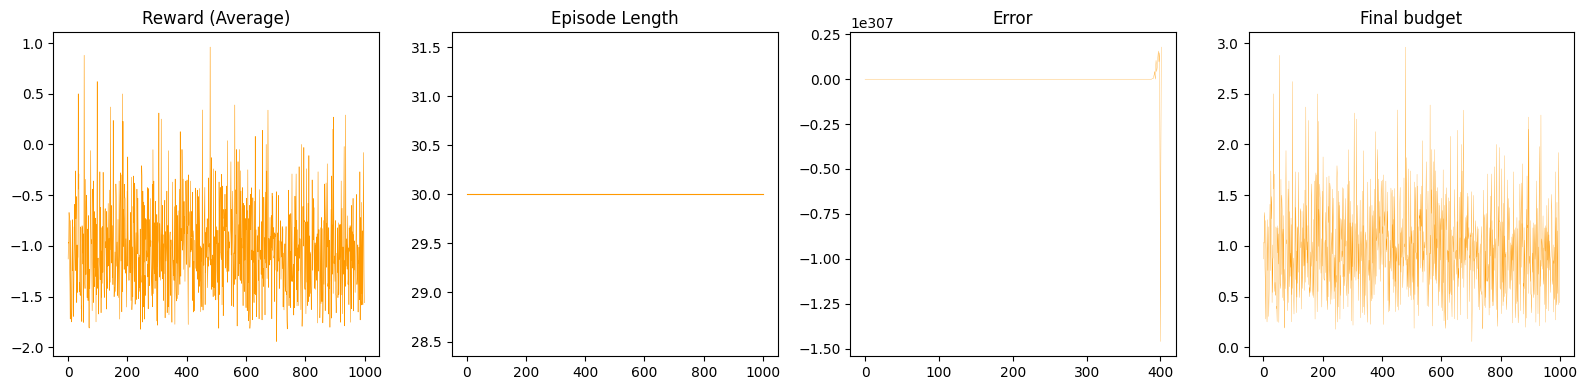

In [21]:
fig, ax = plt.subplots(figsize=(16, 4), ncols=4)
ax[0].plot(range(len(nenv.return_queue)), nenv.return_queue, c='#acc700', linewidth=.4)
ax[0].set_title('Reward (Average)')
ax[1].plot(range(len(nenv.length_queue)), nenv.length_queue, c='#acc700', linewidth=.8)
ax[1].set_title('Episode Length')
ax[2].plot(range(len(SARSA_vfa_agent.training_error)), SARSA_vfa_agent.training_error, c='#acc700', linewidth=.2)
ax[2].set_title('Error')
ax[3].plot(range(len(final_budget_queue)), final_budget_queue, c='#acc700', linewidth=.2)
ax[3].set_title('Final budget')
plt.tight_layout()
plt.show()

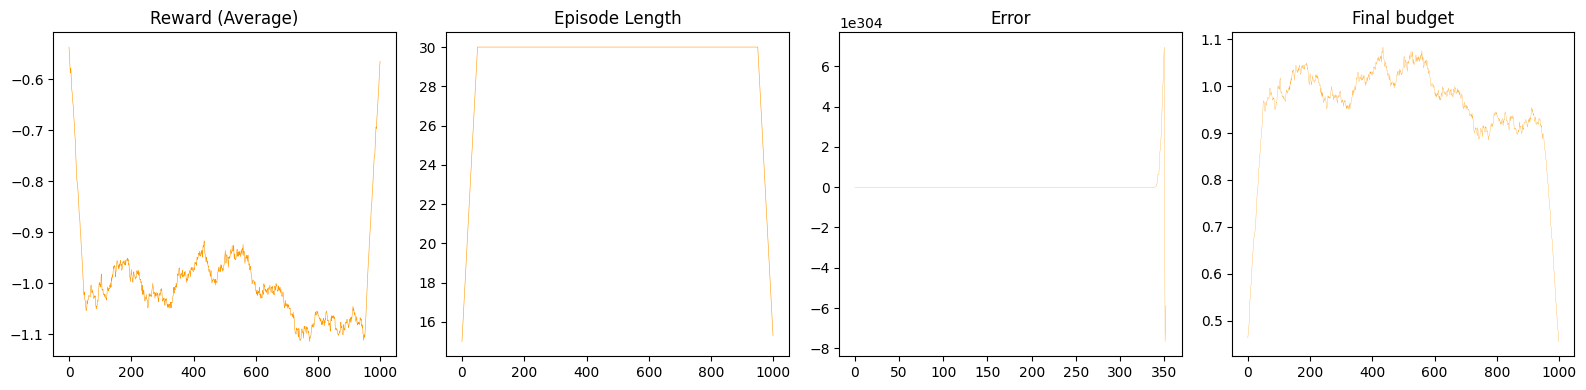

In [22]:
fig, ax = plt.subplots(figsize=(16, 4), ncols=4)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#acc700', linewidth=.4)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#acc700', linewidth=.4)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#acc700', linewidth=.2)
ax[2].set_title('Error')
sns.lineplot(x=range(len(final_budgets)), y=final_budgets, ax=ax[3], c='#acc700', linewidth=.2)
ax[3].set_title('Final budget')
plt.tight_layout()
plt.show()

In [23]:
SARSA_vfa_agent.w

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       dtype=torch.float64, requires_grad=True)